# Import Functions

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
from skimage.feature import peak_local_max
import h5py


In [3]:
import matplotlib.pylab as pylab

params = {'axes.titlesize':20,
          'xtick.direction': 'in' ,
          'ytick.direction' : 'in',
          'xtick.top' : True,
          'ytick.right' : True,
          'ytick.labelsize':16,
          'xtick.labelsize':16
         }

pylab.rcParams.update(params)

In [4]:
torch.__version__

'2.3.1'

In [5]:
#import atomai as aoi
#import kornia as K
import cv2
import scipy
import argparse
import skimage
from skimage.util import random_noise
import glob
from scipy import ndimage
import scipy as sp
import random

In [8]:
import warnings
warnings.filterwarnings('ignore') 

In [9]:
torch.cuda.device_count()

0

# Build two type of mask for two training process

## Set the mask function

In [10]:
def mask_function(img,radius=7,center_coordinates=(100,100)):
    image = np.copy(img.squeeze())
    thickness = -1
    color = 100
    image_2 = cv2.circle(image, center_coordinates, radius, color, thickness)
    image_2 = np.array(image_2)
    mask = (image_2==100)
    mask = np.array(mask)

    return mask

## Set a 200x200 image

In [11]:
mean_ = np.zeros([200,200])

## Build Mask

### define the original 6 dots mask framework 

In [28]:
mask_0 = mask_function(mean_,radius=12,center_coordinates=(99,162))
mask_1 = mask_function(mean_,radius=12,center_coordinates=(154,130))
mask_2 = mask_function(mean_,radius=12,center_coordinates=(154,68))
mask_3 = mask_function(mean_,radius=12,center_coordinates=(99,36))
mask_4 = mask_function(mean_,radius=12,center_coordinates=(45,68))
mask_5 = mask_function(mean_,radius=12,center_coordinates=(45,130))
# Combine all components together
# y larger is lower
mask_up_2 = mask_0+mask_1+mask_2+mask_3+mask_4+mask_5

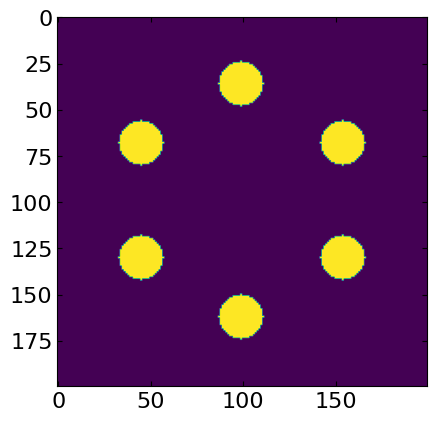

In [29]:
plt.imshow(mask_up_2)

In [30]:
mask_0 = torch.tensor(mask_0)
mask_1 = torch.tensor(mask_1)
mask_2 = torch.tensor(mask_2)
mask_3 = torch.tensor(mask_3)
mask_4 = torch.tensor(mask_4)
mask_5 = torch.tensor(mask_5)

In [33]:
mask_list_2 = [mask_0,mask_1,mask_2,mask_3,mask_4,mask_5]
new_mask_2 = torch.tensor(mask_up_2)

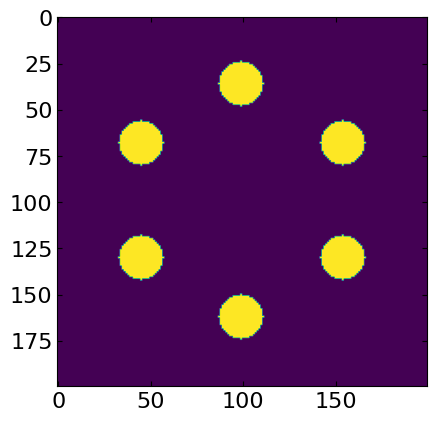

In [34]:
plt.imshow(new_mask_2)

# Loading Data

In [37]:
# Set data direction
data_dir = os.path.abspath("./polycrystal_output4D.mat")


#Load data function 1 for first training process

## Load data function 2 for second training process

In [19]:
def load_data_4_process2(data_dir, pre_rot, w_bg=0.60):
    
    '''
    
        data_dir: path of the dataset
        label_index: path of the pretrained rotation 
    
    '''
    
    f = h5py.File(data_dir,'r')
    op4d = f['output4D']
    op4d = op4d[:,:,28:228,28:228]
    op4d = np.transpose(op4d, (1, 0, 3, 2))
    op4d = op4d.reshape(-1,200,200)
    f.close()
    
    if w_bg == 0:
        
        noisy_data = op4d*1e5/4
    
    else:
    
        noisy_data = np.zeros([65536,200,200])
        im=np.zeros([200,200])
        counts_per_probe = 1e5
        for i in tqdm(range(65536),leave=True,total=65536):
            test_img = np.copy(op4d[i])
            qx = np.fft.fftfreq( im.shape[0], d = 1)
            qy = np.fft.fftfreq( im.shape[1], d = 1)
            qya, qxa = np.meshgrid(qy, qx)
            qxa = np.fft.fftshift(qxa)
            qya = np.fft.fftshift(qya) 
            qra2 = qxa**2 + qya**2
            im_bg = 1./( 1 + qra2 / 1e-2**2 )
            im_bg = im_bg / np.sum(im_bg) 
            int_comb = test_img * (1 - w_bg) + im_bg * w_bg 
            int_noisy = np.random.poisson(int_comb * counts_per_probe) / counts_per_probe
            int_noisy = int_noisy*1e5/4
            noisy_data[i] = int_noisy
        
    del op4d
    
    noisy_data = noisy_data.reshape(-1,1,200,200)
    angle = np.mod(np.arctan2(
        pre_rot[:,1].reshape(256,256),
        pre_rot[:,0].reshape(256,256)),np.pi/3).reshape(-1)
    
    
    # combine the data and label for test
    whole_data_with_rotation = []
    for i in tqdm(range(noisy_data.shape[0]),leave=True, total=noisy_data.shape[0]):
        whole_data_with_rotation.append([noisy_data[i], angle[i]])
        
    return whole_data_with_rotation

# Autoencoder

In [20]:
def crop_small_square(center_coordinates,radius=50):
    
    center_coordinates = torch.round(center_coordinates)
    
    x_coor = (int(center_coordinates[0]-radius),int(center_coordinates[0]+radius))
    
    y_coor = (int(center_coordinates[1]-radius),int(center_coordinates[1]+radius))

    return x_coor,y_coor

In [21]:
def center_of_mass(img,mask,coef=1.5):
    
    cor_x,cor_y = torch.where(mask!=0)
    mean_mass = torch.mean(img[mask])
    mass = F.relu(img[mask]-coef*mean_mass)
    img_after = torch.clone(img)
    img_after[mask] = mass
    
    sum_mass = torch.sum(mass)
    
    if sum_mass == 0:
        weighted_x = torch.sum(cor_x)/len(cor_x)
        weighted_y = torch.sum(cor_y)/len(cor_y)
    else:
        weighted_x = torch.sum(cor_x*mass)/sum_mass
    
        weighted_y = torch.sum(cor_y*mass)/sum_mass
#    plt.figure()
#    plt.imshow(img_after.detach().numpy(),clim=[0,1])
#    plt.figure()
#    plt.plot(weighted_y,weighted_x,'r.')
    return weighted_x,weighted_y

In [22]:
# image: batch input with affine transformation
# mask: the mask added on the diffraction partten
# batch_size: batch of the image
# theta: the batch affine transformation parameter
def revise_size_on_affine_gpu(image, 
                              mask_list, 
                              batch_size, 
                              theta,
                              device,
                              adj_para=None,
                              radius=12,
                              coef=2,
                              pare_reverse=False):
    
#    img0 = np.zeros([image.shape[-1],image.shape[-1]])
    # Add another mask dealing with the diffraction pattern only
    np_img = np.zeros([radius*2,radius*2])
    dot_size = int(4*image.shape[-1]/200)
    small_square_mask = mask_function(np_img,radius=dot_size,center_coordinates=(radius,radius))
    small_square_mask = torch.tensor(small_square_mask,dtype=torch.bool).to(device)

    img = torch.clone(image).to(device)
#    print(img.shape)
    identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(batch_size,1,1).to(device)
    new_theta = torch.cat((theta,identity),axis=1).to(device)
    inver_theta = torch.linalg.inv(new_theta)[:,0:2].to(device)
#    print(theta.shape)
##    print(inver_theta.shape)
#    print('....')
    for j, mask in enumerate(mask_list):
        if mask.shape[0]!= batch_size:
            mask_ = mask.squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1).to(device)
        else:
            mask_ = mask.reshape(batch_size,1,mask.shape[-2],mask.shape[-1]).to(device)
        
#        print(mask_.shape)
#        mask_ = torch.tensor(mask,dtype=torch.float,requires_grad=True).squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1)  
#         grid = F.affine_grid(theta, mask_.size()) 
#         mask_apply_affine = F.grid_sample(mask_, grid)
#         mask_apply_affine = torch.tensor(mask_apply_affine,dtype=torch.bool)

        new_image = image*mask_.to(device)
#        print(new_image.shape)
#        new_image = new_image.detach().numpy()
        for i in range(batch_size):
    #        print(new_image[i].shape)
            center_x,center_y = center_of_mass(new_image[i].squeeze(),mask_[i].squeeze(),coef)
        
            center = torch.tensor([center_x,center_y]).to(device)
 #           print(center)
            x_coor,y_coor = crop_small_square(center_coordinates=center.clone(),radius = radius)
            
            
            #crop small square on image after affine transformation

 
         
            small_image = img[i].squeeze()[x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]].unsqueeze(0).unsqueeze(1).clone().to(device)
            re_grid = F.affine_grid(inver_theta[i].unsqueeze(0).to(device), small_image.size()).to(device) 
            
            if adj_para == None:
                
                re_aff_small_image = F.grid_sample(small_image, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
                
            else:
                
                
                small_image_copy = torch.clone(small_image.squeeze()).to(device)
    #             print(small_image_copy.shape)
    #             print(small_square_mask.shape)
    # Use the same parameter to fit all the diffraction patterns in mask reigon 
                if pare_reverse:
                    small_image_copy[small_square_mask]/=adj_para[i]
                else:
                    small_image_copy[small_square_mask]*=adj_para[i]
                    
                small_image_copy = small_image_copy.unsqueeze(0).unsqueeze(1)


                re_aff_small_image = F.grid_sample(small_image_copy, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
            
    return img

In [23]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
#         self.relu_1 = nn.Tanh()
#         self.relu_2 = nn.Tanh()
#         self.relu_3 = nn.Tanh()
        #self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        #out = self.drop(out)
        out = out.add(x_input)
        
        return out

In [24]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        #self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
#        self.relu = nn.Tanh()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        #output = self.drop(x)
        
        return out

# Rules to use the model architecture 
### Mask should be included since we use affine transformation function, so the "num_mask" should never be "None"
### The format of mask should be tensor list of the mask, so the fixed_mask should be the list of tenosr 

In [25]:
# narrow the range of the adjust parameter for the mask region, since it is not the noise free dataset,
# this will increase the background noise's influence to the MSE loss
# 
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size,device,
                 num_basis=2,fixed_mask=None, num_mask=1, interpolate = False, up_size=800):
        super(Encoder,self).__init__()
        
        self.device = device
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.tanh = nn.Tanh()
        self.before = nn.Linear(input_size,20)
        self.embedding_size = embedding_size
        self.mask_size = num_mask
        
        self.interpolate = interpolate
        self.up_size = up_size
        
        if fixed_mask != None:
        # Set the mask_ to upscale mask if the interpolate set True
            if self.interpolate:
                mask_with_inp = []
                for mask_ in fixed_mask:
                    temp_mask = torch.tensor(mask_.reshape(1,1,self.input_size_0,self.input_size_1),dtype=torch.float)
                    temp_mask = F.interpolate(temp_mask, size=(self.up_size,self.up_size),mode = 'bicubic')
                    temp_mask[temp_mask<0.5]=0
                    temp_mask[temp_mask>=0.5]=1
                    temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
                    mask_with_inp.append(temp_mask)
                    
                self.mask = mask_with_inp
                
            else:
                
                self.mask = fixed_mask
        else:
            self.mask = None
            
        if num_mask == None:
            self.dense = nn.Linear(20+num_basis,self.embedding_size)
        else:
        # Set the all the adj parameter to be the same
            self.dense = nn.Linear(20+num_basis,self.embedding_size+1)
        
        self.for_k = nn.Linear(20,num_basis)
        self.norm = nn.LayerNorm(num_basis)
        self.softmax = nn.Softmax()
        self.num_k_sparse=1
        
    def ktop(self,x):
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()

        k = self.num_k_sparse
        with torch.no_grad():
            if k <= kout.shape[1]:
                for raw in k_no:
                    indices = torch.topk(raw, k)[1].to(self.device)
                    mask = torch.ones(raw.shape, dtype=bool).to(self.device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no
    
    

    def find_type(self):
       
        return self.emoji
    
    def find_mask(self):
       
        return self.mask_size
    
    def rotate_mask(self):
        
        return self.mask
    
    def check_inp(self):
        
        return self.interpolate
    
    def check_upsize(self):
        
        return self.up_size
    
    def forward(self,x,rotate_value = None):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        kout = self.before(out) 
        
        k_out = self.ktop(kout)
        out = torch.cat((kout,k_out),dim=1).to(self.device)
        out = self.dense(out)
        scale_1 = 0.05*nn.Tanh()(out[:,0])+1
        scale_2 = 0.05*nn.Tanh()(out[:,1])+1
        
        if rotate_value!=None:
            
            # use large mask no need to limit to too small range
            
            rotate = rotate_value.reshape(out[:,2].shape) + 0.1*nn.Tanh()(out[:,2])
            
        else:
            
            rotate = nn.ReLU()(out[:,2])
        
        shear_1 = 0.1*nn.Tanh()(out[:,3])
#        shear_2 = 0.1*nn.Tanh()(out[:,4])
#        print(rotate)
        a_1 = torch.cos(rotate)
#        a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)    
        a_4 = torch.ones(rotate.shape).to(self.device)
        a_5 = rotate*0

        
        # combine shear and strain together
        c1 = torch.stack((scale_1,shear_1), dim=1).squeeze()
        c2 = torch.stack((shear_1,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler_shear = torch.stack((c1, c2, c3), dim=2) 

        # Add the rotation after the shear and strain
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3), dim=2)
        
        if self.interpolate == False:
        
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x.size()).to(self.device)
            out_sc_sh = F.grid_sample(x, grid_1)

            grid_2 = F.affine_grid(rotation.to(self.device), x.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2)
            
        
        else:
            
            x_inp = x.view(-1,1,self.input_size_0,self.input_size_1)
            
            x_inp = F.interpolate(x_inp, size=(self.up_size,self.up_size),mode = 'bicubic')
            
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x_inp.size()).to(self.device)
            out_sc_sh = F.grid_sample(x_inp, grid_1, mode = 'bicubic')

            grid_2 = F.affine_grid(rotation.to(self.device), x_inp.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2, mode = 'bicubic')
#        print(output.shape)
        
        
#        print(out_revise)
        

        
        # remove adjust parameter from each mask Region, if multiplied by 0
        mask_parameter = 0*nn.Tanh()(out[:,self.embedding_size:self.embedding_size+1])+1

        if self.interpolate:
            ## Test 1.5 is good for 5% BKG
            out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
                                               self.device,adj_para=mask_parameter,radius=60,coef=1.5)

#            out_revise = F.interpolate(out_revise,size=(self.input_size_0,self.input_size_1),mode = 'bicubic')

            return out_revise,k_out,scaler_shear,rotation, mask_parameter, x_inp

        else:

#                 out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
#                                                    self.device,adj_para=mask_parameter,radius=15)

            return output,k_out,scaler_shear,rotation, mask_parameter

In [26]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size,device,num_basis=2):
        super(Decoder,self).__init__()
        
        self.device = device
        
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(num_basis,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(up_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        
#        input_size = original_step_size[0]*original_step_size[1]
        self.relu_1 = nn.LeakyReLU(0.001)
 

        
    def forward(self,x):
 #       print(x.shape)

        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)
        
#        out = out.view()
#        out = self.softmax(out)
        
        return out

In [27]:
class Joint(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Joint,self).__init__()
        
        self.encoder  = encoder
        self.decoder = decoder
        self.device = device
        self.mask_size = encoder.find_mask()
        
        self.mask = encoder.rotate_mask()
        
        self.interpolate = encoder.check_inp()
        self.up_size = encoder.check_upsize()
        
#        print(self.mask)
        
    def rotate_mask(self):
        
        return self.mask
        
    def forward(self,x,rotate_value=None):

        if self.interpolate:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask, x_inp = self.encoder(x,rotate_value)
            
        else:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask = self.encoder(x,rotate_value)
    
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(self.device)
        
        new_theta_1 = torch.cat((scaler_shear,identity),axis=1).to(self.device)
        new_theta_2 = torch.cat((rotation,identity),axis=1).to(self.device)
        
        inver_theta_1 = torch.linalg.inv(new_theta_1)[:,0:2].to(self.device) 
        inver_theta_2 = torch.linalg.inv(new_theta_2)[:,0:2].to(self.device)
        
        predicted_base = self.decoder(k_out)
        
        if self.interpolate:
            
            predicted_base_inp = F.interpolate(predicted_base, size=(self.up_size,self.up_size),
                                               mode = 'bicubic')
            
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), predicted_base_inp.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), predicted_base_inp.size()).to(self.device)
            
            predicted_rotate = F.grid_sample(predicted_base_inp, grid_2, mode = 'bicubic')
            predicted_input = F.grid_sample(predicted_rotate, grid_1, mode = 'bicubic')
            
        else:
        
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), x.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), x.size()).to(self.device)
        
        
        
            predicted_rotate = F.grid_sample(predicted_base, grid_2)
            
            predicted_input = F.grid_sample(predicted_rotate, grid_1)
        
            
        new_list = []
#        interpolate_list = []

        for mask_ in self.mask:

#                print(x.shape)
#                print(mask_.shape)
            batch_mask = mask_.reshape(1,1,mask_.shape[-2],mask_.shape[-1]).repeat(x.shape[0],1,1,1).to(self.device)

#                batch_mask = batch_mask

#               print(batch_mask.shape)
#               print(x.shape[0])
#                batch_mask = batch_mask

            batch_mask = torch.tensor(batch_mask,dtype=torch.float).to(self.device)

            rotated_mask = F.grid_sample(batch_mask,grid_2)

            
            if self.interpolate:
#                Add reverse affine transform of scale and shear to make all spots in the mask region
                rotated_mask = F.grid_sample(rotated_mask, grid_1)
#                rotated_inp = F.interpolate(rotated_mask,size=(x.shape[-2],x.shape[-1]),mode='bicubic')
            
#                 rotated_inp[rotated_inp<0.5]=0
#                 rotated_inp[rotated_inp>=0.5]=1
                

#                 rotated_inp = torch.tensor(rotated_inp,dtype=torch.bool).squeeze().to(self.device)

#                 interpolate_list.append(rotated_inp)
                
            
            rotated_mask[rotated_mask<0.5] = 0
            rotated_mask[rotated_mask>=0.5] = 1
            
            rotated_mask = torch.tensor(rotated_mask,dtype=torch.bool).squeeze().to(self.device)

            new_list.append(rotated_mask)


        if self.interpolate:
         ## 1.5 is totally fine for 5% bkg
            predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
                                                               self.device, adj_para=adj_mask,radius=60,coef=1.5,pare_reverse=True)
#             predicted_input_revise = F.interpolate(predicted_input_revise,size=(x.shape[-1],x.shape[-2]),
#                                                     mode = 'bicubic')

#             else:
#                 predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
#                                                                    self.device, adj_para=adj_mask,radius=15,pare_reverse=True



############ change predicted_base to predicted_base_inp, delete interpolate_list,add new_list
            return predicted_revise,predicted_base_inp,predicted_input_revise,k_out,scaler_shear,rotation,adj_mask,new_list,x_inp

        else:
            return predicted_revise,predicted_base,predicted_input,k_out,scaler_shear,rotation,adj_mask,new_list
         
        

In [28]:
device = torch.device('cuda')

In [29]:
device

device(type='cuda')

In [30]:
type(mask_list_2) == list

True

# Setting Parameters

## Parameters shared with both model architecture 

In [31]:
en_original_step_size=[200,200]
pool_list=[5,4,2]
de_original_step_size = [5,5]
up_list = [2,4,5]
embedding_size=4
conv_size =128
num_basis=1
up_size=800

## Parameters for first Training Process

# Set Model Structure

# Use the generated rotation and scale shear to check on the base position and create new mask region

In [32]:
def inverse_base(name_of_file, input_mask_list, coef=2, radius = 7):
    
    load_file = h5py.File(name_of_file+'.h5','r')
    load_base = load_file['base'][0].squeeze()
    
    
    
    base_ = torch.tensor(load_base,dtype=torch.float).reshape(1,1,load_base.shape[-1],load_base.shape[-2])
    
    center_mask_list,rotate_center = center_mask_list_function(base_,input_mask_list,coef,radius=radius)
    
    
    
    return center_mask_list, rotate_center

In [45]:
file_py4DSTEM = 'py4DSTEM_strain.h5'
f = h5py.File(file_py4DSTEM,'r')
strain_map = f['4DSTEM_experiment']['data']['realslices']['strain_map']['data'][:]

In [46]:
rotation_ = np.load("25Percent_rotation_071323.npy")
rotation_.shape

(65536, 2)

# Add random rotation to the rotation from first training process 

In [47]:
def add_disturb(rotation,dist = -15):
    angles = np.rad2deg(np.arctan2(
                        rotation[:,1].reshape(256,256),
                        rotation[:,0].reshape(256,256)))
    angles = angles.reshape(-1)
    angles = angles+dist
    
    angles = np.deg2rad(angles)
    
    new_rotation = np.zeros([angles.shape[0],2])
    
    cos_ = np.cos(angles)
    sin_ = np.sin(angles)
    
    new_rotation[:,0] = cos_
    new_rotation[:,1] = sin_
    
    return new_rotation
    

In [48]:
new_rotation = add_disturb(rotation_)

In [49]:
theta_Colin = np.mod(np.rad2deg(strain_map[:,:,3]),60)
theta_Shuyu = np.mod(np.rad2deg(np.arctan2(
        new_rotation[:,1].reshape(256,256),
        new_rotation[:,0].reshape(256,256))),
    60.0)
angle_diff = (theta_Shuyu-theta_Colin).reshape(-1)
index_= np.where(angle_diff<0)
angle_diff[index_]+=60

In [50]:
theta_ = np.pi*np.mean(angle_diff)/180
theta_ = torch.tensor(theta_,dtype=torch.float)

In [51]:
theta_

tensor(0.1430)

In [52]:
subtract = torch.tensor(angle_diff,dtype=torch.float)
torch.var(subtract, unbiased=False)

tensor(1.5889)

# Recorrect the Function for rotate mask list

In [53]:
def rotate_mask_list(mask_list,theta_):
    modified_mask_list_2 = []
    a_1 = torch.cos(theta_).reshape(1,1)
    a_2 = torch.sin(theta_).reshape(1,1)
    a_5 = torch.zeros([1,1])
    b1 = torch.stack((a_1,a_2), dim=1)
    b2 = torch.stack((-a_2,a_1), dim=1)
    b3 = torch.stack((a_5,a_5), dim=1)
    rotation = torch.stack((b1, b2, b3), dim=2)
    rotation = rotation.reshape(1,2,3)
    zero_tensor = torch.zeros(mask_list[0].shape)
    print(zero_tensor.shape)
    zero_tensor = zero_tensor.reshape(1,1,zero_tensor.shape[-2],zero_tensor.shape[-1])
    grid_2 = F.affine_grid(rotation, zero_tensor.size())
                           
    
    for mask_ in mask_list:
        
        tmp = torch.clone(mask_).reshape(1,1,mask_.shape[-2],mask_.shape[-1])
        tmp = torch.tensor(tmp, dtype=torch.float)
        rotate_tmp = F.grid_sample(tmp,grid_2)
        rotate_tmp = torch.tensor(rotate_tmp,dtype=torch.bool).squeeze()
        modified_mask_list_2.append(rotate_tmp)
    
    
    rotate_mask_up = torch.clone(modified_mask_list_2[0])
    
    for i in range(1,len(mask_list)):
        rotate_mask_up+=modified_mask_list_2[i]
        
    return modified_mask_list_2,rotate_mask_up

In [54]:
modified_mask_list_2,rotate_mask_up = rotate_mask_list(mask_list_2,theta_)

torch.Size([200, 200])


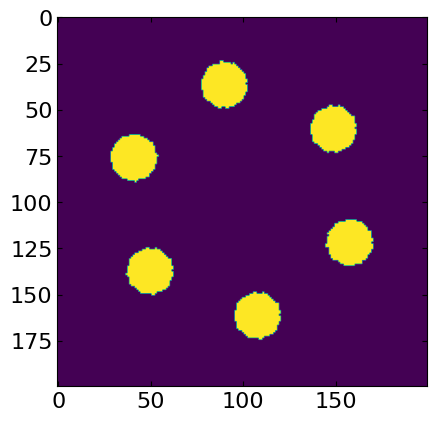

In [55]:
plt.imshow(rotate_mask_up)

# Set new circle with small radius

## Generate base and recorrect the mask region and decrease the mask region

In [56]:
def upsample_mask(mask_list,input_size, up_size):
    
    if mask_list[0].shape[-1]==up_size:
        return mask_list
    
    mask_with_inp = []
    for mask_ in mask_list:
        temp_mask = torch.tensor(mask_.reshape(1,1,input_size,input_size),dtype=torch.float)
        temp_mask = F.interpolate(temp_mask, size=(up_size,up_size),mode = 'bicubic')
        temp_mask[temp_mask<0.5]=0
        temp_mask[temp_mask>=0.5]=1
        temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
        mask_with_inp.append(temp_mask)

    return mask_with_inp

In [57]:
def center_mask_list_function(image,mask_list,coef,radius=7):
    
    center_mask_list = []
    mean_ = np.zeros([image.shape[-2],image.shape[-1]])
    
    input_size = mask_list[0].shape[-1]
    up_size = image.shape[-1]
    
    if input_size!=up_size:
        
        mask_list = upsample_mask(mask_list,input_size,up_size)
    
    for j, mask in enumerate(mask_list):
        

        mask_ = mask.reshape(1,1,mask.shape[-2],mask.shape[-1])

        new_image = image*mask_

        center_x,center_y = center_of_mass(new_image.squeeze(),mask_.squeeze(),coef)
        
        center_x = int(np.round(np.array(center_x)))
        center_y = int(np.round(np.array(center_y)))
        print(center_x,center_y)
        
        small_mask = mask_function(mean_,radius=radius,center_coordinates=(center_y,center_x))
        
        small_mask = torch.tensor(small_mask,dtype = torch.bool)
        
        center_mask_list.append(small_mask)
        
    if input_size!=up_size:
        
        center_mask_list = upsample_mask(center_mask_list,up_size,input_size)
        
    rotate_mask_up = torch.clone(center_mask_list[0])
    
    for i in range(1,len(center_mask_list)):
        rotate_mask_up+=center_mask_list[i]
        
    return center_mask_list,rotate_mask_up

## Parameters for second Training Process

In [58]:
num_mask_2 = 6
fixed_mask_2 = modified_mask_list_2
interpolate_2 = True

## Model for second process training

In [59]:
def make_model_2(device,
               en_original_step_size = en_original_step_size, 
               pool_list = pool_list, 
               de_original_step_size = de_original_step_size,
               up_list = up_list,
               embedding_size = embedding_size,
               conv_size = conv_size,
               num_basis = num_basis,
               num_mask = num_mask_2,
               fixed_mask = fixed_mask_2,
               learning_rate = 3e-5,
               interpolate = interpolate_2,
               up_size = up_size
               ):
    
    encoder = Encoder(original_step_size=en_original_step_size,
                      pool_list=pool_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis,
                      fixed_mask = fixed_mask,
                      num_mask=num_mask,
                      interpolate = interpolate,
                      up_size = up_size).to(device)
    decoder = Decoder(original_step_size=de_original_step_size,
                      up_list=up_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis).to(device)
    join = Joint(encoder,decoder,device).to(device)
    
    optimizer = optim.Adam(join.parameters(), lr=learning_rate)
    
    join = torch.nn.parallel.DataParallel(join)
    
    return encoder, decoder, join, optimizer

# Loss Function for Second Process
## loss function used for small batch size

In [60]:
def loss_function_2nd(join,
                      train_iterator,
                      optimizer,
                      device,
                      coef1 = 0,
                      coef2 = 0,
                      coef3 = 0,
                      ln_parm = 1, 
                      mask_ = None,
                      up_inp = False
                     ):

    weight_decay = coef1
    scale_coef = coef2
    shear_coef = coef3

    # set the train mode
    join.train()

    # loss of the epoch
    train_loss = 0
    L2_loss = 0 
    Scale_Loss = 0
    Shear_Loss = 0 
    
    for x,y in tqdm(train_iterator, leave=True, total=len(train_iterator)):
     

        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()
        
        if up_inp:
            
            predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list,x_inp = join(x,y)
            
#             print(mask_[0].shape)
#             print(x.shape[-1])
#             print(x_inp.shape[-1])
            
            mask_ = upsample_mask(mask_,x.shape[-1], x_inp.shape[-1])
            
        else:
            predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list= join(x,y)
        

        l2_loss = weight_decay*torch.norm(predicted_base.squeeze(), p=ln_parm)/x.shape[0]
        scale_loss = scale_coef*(torch.mean(F.relu(abs(theta_1[:,0,0]-1)-0.04))\
                                 +torch.mean(F.relu(abs(theta_1[:,1,1]-1)-0.04)))
        shear_loss = shear_coef*torch.mean(F.relu(abs(theta_1[:,0,1])-0.04)) 
        
        loss  = (l2_loss + scale_loss + shear_loss)*len(mask_)

        for i,mask in enumerate(mask_):

            
            loss += F.mse_loss(predicted_base.squeeze()[:,mask], predicted_x.squeeze()[:,mask], reduction='mean')
            #set the loss for the generated input and input
            sub_loss = 0
            for k in range(x.shape[0]):
                
                if up_inp:
                    sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x_inp[k].squeeze()[new_list[i][k]], reduction='mean')
                else:
                    sub_loss += F.mse_loss(predicted_input[k].squeeze()[new_list[i][k]], x[k].squeeze()[new_list[i][k]], reduction='mean')

            loss += (sub_loss/x.shape[0])

        loss = loss/(len(mask_)*15)

        if loss>1.5:
            loss  =  (l2_loss + scale_loss + shear_loss)*len(mask_)
            for i,mask in enumerate(mask_):

                loss += F.l1_loss(predicted_base.squeeze()[:,mask], predicted_x.squeeze()[:,mask], reduction='mean')

                sub_loss = 0
                for k in range(x.shape[0]):

                    if up_inp:
                        sub_loss += F.l1_loss(predicted_input[k].squeeze()[new_list[i][k]], x_inp[k].squeeze()[new_list[i][k]], reduction='mean')
                    else:
                        sub_loss += F.l1_loss(predicted_input[k].squeeze()[new_list[i][k]], x[k].squeeze()[new_list[i][k]], reduction='mean')
                loss += (sub_loss/x.shape[0])

            loss = loss/(len(mask_)*15)
            loss = loss- 1

        if loss>(2*len(mask_)):
            loss=2*len(mask_)+l2_loss + scale_loss + shear_loss

                
        # backward pass
        train_loss += loss.item()
        L2_loss += l2_loss
        Scale_Loss += scale_loss
        Shear_Loss += shear_loss
        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss, L2_loss, Scale_Loss, Shear_Loss

## loss function used for large batch size

## Validate Loss fuction

# Set function for performance monitor

## Polar Decomposition 

## The function for the scale and shear evaluation

# Second training process
### set training parameters

## RayTune Training Process

In [67]:
#import wandb

In [68]:
# sweep_config = {
#   "name" : "3_14_wustl_clean_2nd_Process_LR_TUNNING",
#   "method" : "grid",
#   "parameters" : {
      
#     "learning_rate" : {
#         "values" : [5e-6,8e-6,1e-5,1.5e-5]
#     },
      
#     "max_rate" : {
#         "values" : [5e-5]
#     },
      
#     "l1_regular" : {
#         "values" : [1e-8]
#     },
#     "scale_regular" : {
#         "values" : [10] 
#     },
#     "shear_regular" : {
#         "values" : [10]
#     },
#   }
# }

# sweep_id = wandb.sweep(sweep_config,project="3_14_wustl_clean_2nd_Process_LR_TUNNING", entity="shuyuqin")

In [69]:
data_dir = os.path.abspath("./polycrystal_output4D.mat")
folder_path = os.path.abspath("./07_13_25Percent_Upsample_SCALE_SHEAR_On_MASK_Test_large_MASK_update_MASK_once_15DEGREE")
#pretrain_weight = os.path.abspath("./04_20_RAYTUNE_lr:0.000065_scale_cof:80.350_shear_cof:16.100_MAE:0.0063_seed:42_epoch:0004_trainloss:0.002384_l1:0.00014_scal:0.00000_shr:0.00000.pkl")

In [70]:
#pretrain_weight

# Use Cross Validation and check with training 

In [79]:
def Ray_Tune_Cross_Validation_Second_Process(config, 
                                     data_dir,
                                     rotation_ = new_rotation,
                                     label_xx = label_xx,
                                     label_yy = label_yy,
                                     label_xy = label_xy,
                                     epochs=20,
                                     activity_regular='l1',
                                     mask_= modified_mask_list_2,
                                     check_mask = modified_mask_list_2,
                                     Up_inp = interpolate_2,
                                     epoch_ = None,
                                     file_path = None,
                                     folder_path=folder_path,
            #                         pretrain_weight = pretrain_weight,
                                     best_train_loss= None,
                                     set_scheduler = False,
                                    ):
        
            
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda"
        
        
        seed = 42
        np.random.seed(seed)
        torch.manual_seed(seed)
        print('.........a step.........')

    #        print(config["learning_rate"])

        print('.........b step.........')

        learning_rate = config["learning_rate"]
#        max_rate = config["max_rate"]

        coef_1 = config["l1_regular"]        
        coef_2 = config["scale_regular"]
        coef_3 = config["shear_regular"]
        batch_para = config["batch_para"]


        learning_rate = int(learning_rate*1e6)/1e6
#        max_rate = int(max_rate*1e6)/1e6
        coef_1 = int(coef_1*1e9)/1e9
        coef_2 = int(coef_2*1e2)/1e2
        coef_3 = int(coef_3*1e2)/1e2
        
        patience = 0
        
        print("........successfully load parameters")
        
        whole_data_with_rotation = load_data_4_process2(data_dir,rotation_,w_bg=0.25)
        
        encoder, decoder, join, optimizer = \
        make_model_2(device,learning_rate = learning_rate,fixed_mask = mask_)
        
        radius = 45
        
            
        if set_scheduler:
        
            lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=max_rate,
                                                  step_size_up=20,cycle_momentum=False)
        else: 
            
            lr_scheduler = None
        

        
        if activity_regular == 'l1':
            regul_type = 1
            
        elif activity_regular == 'l2':
            regul_type = 2
            
        else:
            regul_type = 0
            
     
        print('..........successfully generate model')
        
        
        train_iterator = DataLoader(whole_data_with_rotation, batch_size=64, shuffle=True, num_workers=0)
#        converge_iterator = DataLoader(whole_data_with_rotation, batch_size=8, shuffle=True, num_workers=0)
        
        test_iterator = DataLoader(whole_data_with_rotation, batch_size=128, shuffle=False, num_workers=0)

        N_EPOCHS = epochs

        if best_train_loss == None:
            best_train_loss = float('inf')


        if epoch_==None:
            start_epoch = 0
        else:
            start_epoch = epoch_+1
        print('...........successfully generate train interator')

        for epoch in range(start_epoch,epochs):
    #    This loss function include the entropy loss with increasing coefficient value
    
            if epoch >0 and epoch<2:
            
                encoder, decoder, join, optimizer = \
                        make_model_2(device,learning_rate = learning_rate,fixed_mask = mask_)
                
                
                check_ccc = torch.load(file_path) 

                join.load_state_dict(check_ccc['net'])
                encoder.load_state_dict(check_ccc['encoder'])
                decoder.load_state_dict(check_ccc['decoder'])
                optimizer.load_state_dict(check_ccc['optimizer'])
                
#               coef_1 = 1e-13
                
            optimizer.param_groups[0]['lr'] = learning_rate   
                
            
            
    
            train = loss_function_2nd(join,train_iterator,
                                  optimizer,device,coef_1,coef_2,coef_3,regul_type,mask_,interpolate_2)

            input_length = len(train_iterator)
                
                
            train_loss,L2_loss,Scale_Loss, Shear_Loss = train
            
            train_loss /= input_length
            L2_loss /= input_length
            Scale_Loss /= input_length
            Shear_Loss /= input_length

    #        VAE_L /= len(train_iterator)
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
    #        print(f'......... VAE Loss: {VAE_L:.4f}')
            print('.............................')
        
            
#             name_of_file = folder_path + f'/L1:{coef_1:.10f}_scale:{coef_2:.3f}_shear:{coef_3:.3f}_lr:{learning_rate:.6f}_batchpara:{batch_para:02d}_Epoch:{epoch:04d}_trainloss:{train_loss:.6f}_'

#             exx_Shuyu,eyy_Shuyu,exy_Shuyu = Show_Process(join,test_iterator,mask_,name_of_file,device,interpolate_2)

#             combine_loss = Generate_scale_shear_loss(exx_Shuyu,eyy_Shuyu,exy_Shuyu,label_xx,label_yy,label_xy)
            
            if epoch==0:
        
                
                
                center_mask_list, rotate_center = \
                inverse_base(name_of_file, check_mask, radius = radius)

     #           rotation_ = load_rotation_

                mask_ = center_mask_list

            # Save every weight to be prepared for loading
    
            with tune.checkpoint_dir(epoch):
            


                checkpoint = {
                    "net": join.state_dict(),
                    "encoder":encoder.state_dict(),
                    "decoder":decoder.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    "epoch": epoch,
                    'mse_loss': train_loss,
                }
                if epoch >=0:
                    lr_ = format(optimizer.param_groups[0]['lr'],'.6f')
    #                    l1_form = format(coef_1,'.4f')
                    scale_form = format(coef_2,'.3f')
                    shear_form = format(coef_3,'.3f')
                    file_path = folder_path+'/07_13_15D_upsample_update_mask_once_lr:'+lr_+'_scale_cof:'+scale_form+'_shear_cof:'+shear_form+\
                               f'_MAE:{combine_loss:.4f}_seed:{seed:02d}_epoch:{epoch:04d}_trainloss:{train_loss:.6f}_l1:{L2_loss:.5f}_scal:{Scale_Loss:.5f}_shr:{Shear_Loss:.5f}.pkl'
                    torch.save(checkpoint, file_path)
                    
                if epoch>=1:
                
                    if best_train_loss > train_loss:
                        best_train_loss = train_loss

                        patience = 0

                        learning_rate = 1.2 * learning_rate

                    else:
                        patience +=1

                        if patience >0:
                            learning_rate = learning_rate*0.8
                    
                tune.report(loss=train_loss, score=combine_loss)

            if lr_scheduler!= None:
                lr_scheduler.step()


In [80]:
scheduler = ASHAScheduler(
    metric="score",
    mode="min",
    max_t=18,
    grace_period=6,
    reduction_factor=8)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["score", "training_iteration"])

In [ ]:
config = {
    "l1_regular": tune.loguniform(1e-7, 5e-7),
    "scale_regular": tune.loguniform(50, 100),
    "shear_regular": tune.loguniform(1, 50),
    "learning_rate": tune.loguniform(5e-6, 2e-4),
    "max_rate": tune.loguniform(1e-4, 2e-4),
    "batch_para": tune.choice([1])
}

tuner = tune.run(partial(Ray_Tune_Cross_Validation_Second_Process,data_dir = data_dir), 
                 resources_per_trial={"cpu": 4, "gpu": 1},
                 config=config,
                 num_samples=200,
                 scheduler=scheduler,
#                 progress_reporter=reporter
                )
#results = tuner.fit()
print(tuner.get_best_config(metric="score", mode="min"))

2023-07-13 15:38:28,312	INFO worker.py:1528 -- Started a local Ray instance.
2023-07-13 15:38:28,850	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


(func pid=2767420) .........a step.........
(func pid=2767420) .........b step.........
(func pid=2767420) ........successfully load parameters
(func pid=2767473) .........a step.........
(func pid=2767473) .........b step.........
(func pid=2767473) ........successfully load parameters
(func pid=2767457) .........a step.........
(func pid=2767457) .........b step.........
(func pid=2767457) ........successfully load parameters


  4%|▍         | 2733/65536 [00:03<01:27, 717.33it/s]


 10%|▉         | 6405/65536 [00:08<01:23, 708.11it/s]


 15%|█▌        | 10075/65536 [00:14<01:18, 710.40it/s]


 21%|██        | 13777/65536 [00:19<01:11, 721.43it/s]


 27%|██▋       | 17422/65536 [00:24<01:06, 719.77it/s]


 32%|███▏      | 21046/65536 [00:29<01:02, 709.55it/s]


 38%|███▊      | 24758/65536 [00:34<00:56, 721.05it/s]


 44%|████▎     | 28554/65536 [00:39<00:51, 722.94it/s]


 49%|████▉     | 32204/65536 [00:44<00:46, 715.68it/s]


 55%|█████▍    | 35926/65536 [00:50<00:41, 719.25it/s]


 60%|██████    | 39649/65536 [00:55<00:35, 723.96it/s]


 66%|██████▌   | 43372/65536 [01:00<00:30, 724.05it/s]


 72%|███████▏  | 47168/65536 [01:05<00:25, 723.20it/s]


 78%|███████▊  | 50891/65536 [01:10<00:20, 723.64it/s]


 83%|████████▎ | 54541/65536 [01:15<00:15, 723.29it/s]


 89%|████████▉ | 58264/65536 [01:20<00:10, 723.33it/s]


 95%|█████████▍| 61987/65536 [01:26<00:04, 725.00it/s]


 98%|█████████▊| 64485/65536 [01:30<00:01, 720.33it/s]
(func pid=2767457) /tmp/ipykernel_2766228/4157474335.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(func pid=2767457) /tmp/ipykernel_2766228/4157474335.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|█████████▉| 65491/65536 [01:30<00:00, 724.27it/s]
(func pid=2767420) /tmp/ipykernel_2766228/4157474335.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(func pid=2767420) /tmp/ipykernel_2766228/4157474335.py:49: UserWarning: To copy construct from a tensor, it is recommende

100%|██████████| 65536/65536 [00:00<00:00, 1186199.05it/s]
(func pid=2767473) /tmp/ipykernel_2766228/4157474335.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(func pid=2767473) /tmp/ipykernel_2766228/4157474335.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/1024 [00:00<?, ?it/s]


(func pid=2767420) ..........successfully generate model
(func pid=2767420) ...........successfully generate train interator


(func pid=2767420) /tmp/ipykernel_2766228/4157474335.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=2767420) /home/jca92/anaconda3/envs/shuyu/lib/python3.10/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
(func pid=2767420)   warnings.warn(
(func pid=2767420) /home/jca92/anaconda3/envs/shuyu/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
(func pid=2767420)   warnings.warn(
(func pid=2767420) /tmp/ipykernel_2766228/75522181.py:77: UserWarning: To copy cons

(func pid=2767473) ..........successfully generate model
(func pid=2767473) ...........successfully generate train interator


  0%|          | 0/1024 [00:00<?, ?it/s]


(func pid=2767457) ..........successfully generate model
(func pid=2767457) ...........successfully generate train interator


(func pid=2767473) /tmp/ipykernel_2766228/4157474335.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=2767473) /home/jca92/anaconda3/envs/shuyu/lib/python3.10/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
(func pid=2767473)   warnings.warn(
(func pid=2767473) /home/jca92/anaconda3/envs/shuyu/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
(func pid=2767473)   warnings.warn(
(func pid=2767457) /tmp/ipykernel_2766228/4157474335.py:74: UserWarning: Implicit d

  8%|▊         | 78/1024 [05:23<1:05:10,  4.13s/it]


 13%|█▎        | 130/1024 [08:56<1:01:21,  4.12s/it]


 18%|█▊        | 185/1024 [12:32<56:36,  4.05s/it]


 24%|██▎       | 243/1024 [16:10<52:04,  4.00s/it]


 29%|██▊       | 292/1024 [19:45<49:19,  4.04s/it]


 33%|███▎      | 342/1024 [23:24<46:34,  4.10s/it]


 39%|███▊      | 395/1024 [27:00<42:51,  4.09s/it]


 45%|████▍     | 460/1024 [30:39<37:29,  3.99s/it]


 49%|████▉     | 506/1024 [34:11<34:52,  4.04s/it]


 55%|█████▍    | 560/1024 [37:50<31:15,  4.04s/it]


 61%|██████    | 623/1024 [41:29<26:34,  3.98s/it]


 64%|██████▍   | 660/1024 [45:03<25:04,  4.13s/it]


 70%|███████   | 721/1024 [48:41<20:26,  4.05s/it]


 77%|███████▋  | 786/1024 [52:22<15:54,  4.01s/it]


 82%|████████▏ | 840/1024 [55:59<12:21,  4.03s/it]


 86%|████████▌ | 882/1024 [59:35<09:35,  4.05s/it]


 92%|█████████▏| 947/1024 [1:03:08<05:07,  3.99s/it]


 96%|█████████▋| 986/1024 [1:06:35<02:33,  4.05s/it]


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767420) Epoch 0, Train Loss: 0.0038
(func pid=2767420) .............................


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767457) Epoch 0, Train Loss: 0.0038
(func pid=2767457) .............................


  9%|▉         | 46/512 [01:43<17:27,  2.25s/it]


(func pid=2767473) Epoch 0, Train Loss: 0.0043
(func pid=2767473) .............................


 20%|█▉        | 102/512 [03:53<15:51,  2.32s/it]


 21%|██        | 108/512 [04:17<16:13,  2.41s/it]


 31%|███▏      | 161/512 [06:23<13:55,  2.38s/it]


 42%|████▏     | 214/512 [08:30<11:54,  2.40s/it]


 52%|█████▏    | 267/512 [10:38<09:48,  2.40s/it]


 69%|██████▉   | 352/512 [13:33<06:09,  2.31s/it]


 79%|███████▉  | 406/512 [15:41<04:14,  2.40s/it]


 90%|████████▉ | 460/512 [17:49<02:03,  2.37s/it]


 93%|█████████▎| 476/512 [18:26<01:23,  2.33s/it]


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,score,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
Ray_Tune_Cross_Validation_Second_Process_507b0_00000,2023-07-13_21-30-35,False,,4b5ed96d730542d98533b2cbd2720265,shenron.urcf.drexel.edu,4,0.00344543,10.246.227.235,2767420,0.00713754,True,21123.7,5222.95,21123.7,1689283835,0,,4,507b0_00000,0.00351906
Ray_Tune_Cross_Validation_Second_Process_507b0_00001,2023-07-13_21-36-57,False,,3ea71ada741342e3811e0d12c2a00b0a,shenron.urcf.drexel.edu,4,0.00349425,10.246.227.235,2767457,0.00624975,True,21503.1,5327.91,21503.1,1689284217,0,,4,507b0_00001,0.00259995
Ray_Tune_Cross_Validation_Second_Process_507b0_00002,2023-07-13_21-46-52,False,,b6f6f975f2af462baab2fcd3bc4ea610,shenron.urcf.drexel.edu,4,0.00350869,10.246.227.235,2767473,0.00656486,True,22098.7,5457.36,22098.7,1689284812,0,,4,507b0_00002,0.0026679


(func pid=2767420) 657 431
(func pid=2767420) 502 641
(func pid=2767420) 245 612
(func pid=2767420) 143 373
(func pid=2767420) 298 163
(func pid=2767420) 555 193


 94%|█████████▎| 479/512 [19:04<01:19,  2.40s/it]


(func pid=2767457) 658 439
(func pid=2767457) 498 643
(func pid=2767457) 240 607
(func pid=2767457) 143 366
(func pid=2767457) 302 161
(func pid=2767457) 560 198


  2%|▏         | 20/1024 [01:21<1:07:44,  4.05s/it]


(func pid=2767473) 657 429
(func pid=2767473) 505 639
(func pid=2767473) 248 612
(func pid=2767473) 144 375
(func pid=2767473) 295 165
(func pid=2767473) 552 191


  9%|▉         | 95/1024 [06:18<1:01:35,  3.98s/it]


 12%|█▏        | 125/1024 [08:27<1:00:44,  4.05s/it]


 15%|█▌        | 155/1024 [10:41<1:00:37,  4.19s/it]


 23%|██▎       | 232/1024 [15:42<53:30,  4.05s/it]


 31%|███       | 313/1024 [20:46<47:08,  3.98s/it]


 33%|███▎      | 339/1024 [22:58<47:40,  4.18s/it]


 38%|███▊      | 392/1024 [26:36<42:44,  4.06s/it]


 41%|████      | 420/1024 [28:53<41:02,  4.08s/it]


 46%|████▌     | 473/1024 [32:29<37:42,  4.11s/it]


 51%|█████▏    | 526/1024 [36:07<34:08,  4.11s/it]


 57%|█████▋    | 579/1024 [39:47<31:01,  4.18s/it]


 65%|██████▍   | 661/1024 [44:48<24:34,  4.06s/it]


 70%|██████▉   | 715/1024 [48:27<20:59,  4.08s/it]


 75%|███████▌  | 769/1024 [52:07<17:15,  4.06s/it]


 84%|████████▍ | 858/1024 [57:11<11:03,  4.00s/it]


 86%|████████▌ | 876/1024 [59:22<10:02,  4.07s/it]


 87%|████████▋ | 894/1024 [1:01:33<08:50,  4.08s/it]


 99%|█████████▉| 1018/1024 [1:07:49<00:23,  3.99s/it]


100%|██████████| 1024/1024 [1:08:13<00:00,  4.00s/it]


(func pid=2767420) Epoch 1, Train Loss: 0.0039
(func pid=2767420) .............................


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767457) Epoch 1, Train Loss: 0.0040
(func pid=2767457) .............................


100%|██████████| 1024/1024 [1:10:25<00:00,  4.13s/it]


(func pid=2767473) Epoch 1, Train Loss: 0.0036
(func pid=2767473) .............................


 37%|███▋      | 190/512 [07:06<12:05,  2.25s/it]


 34%|███▍      | 174/512 [06:41<13:00,  2.31s/it]


 31%|███       | 158/512 [06:25<14:41,  2.49s/it]


 56%|█████▌    | 285/512 [10:57<08:40,  2.29s/it]


 81%|████████▏ | 416/512 [15:40<03:37,  2.27s/it]


 62%|██████▏   | 315/512 [12:48<07:51,  2.39s/it]


  1%|          | 7/1024 [00:27<1:06:48,  3.94s/it]


 53%|█████▎    | 35061/65536 [00:00<00:00, 69842.13it/s]


 96%|█████████▋| 493/512 [20:06<00:46,  2.47s/it]


  9%|▉         | 90/1024 [05:59<1:02:15,  4.00s/it]


  8%|▊         | 85/1024 [05:55<1:04:28,  4.12s/it]


 13%|█▎        | 136/1024 [09:29<1:01:49,  4.18s/it]


 25%|██▍       | 251/1024 [16:43<51:30,  4.00s/it]


 30%|██▉       | 305/1024 [20:20<47:56,  4.00s/it]


 28%|██▊       | 291/1024 [20:18<50:58,  4.17s/it]


 33%|███▎      | 343/1024 [23:56<47:30,  4.19s/it]


 46%|████▌     | 468/1024 [31:12<37:05,  4.00s/it]


 44%|████▎     | 447/1024 [31:10<40:15,  4.19s/it]


 61%|██████▏   | 629/1024 [41:22<26:02,  3.95s/it]


 62%|██████▏   | 631/1024 [42:05<26:11,  4.00s/it]


 67%|██████▋   | 685/1024 [45:42<22:41,  4.02s/it]


 78%|███████▊  | 794/1024 [52:12<15:05,  3.94s/it]


 69%|██████▉   | 706/1024 [49:17<22:14,  4.20s/it]


 74%|███████▍  | 758/1024 [52:53<18:29,  4.17s/it]


 88%|████████▊ | 901/1024 [1:00:07<08:14,  4.02s/it]


 84%|████████▍ | 860/1024 [1:00:01<11:21,  4.15s/it]


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767420) Epoch 2, Train Loss: 0.0035
(func pid=2767420) .............................


 15%|█▌        | 77/512 [02:52<16:07,  2.23s/it]


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767457) Epoch 2, Train Loss: 0.0037
(func pid=2767457) .............................


 94%|█████████▍| 963/1024 [1:07:11<04:14,  4.18s/it]


 46%|████▌     | 236/512 [08:51<10:25,  2.27s/it]


100%|██████████| 1024/1024 [1:11:23<00:00,  4.18s/it]


(func pid=2767473) Epoch 2, Train Loss: 0.0035
(func pid=2767473) .............................


 10%|█         | 53/512 [02:09<18:41,  2.44s/it]


 55%|█████▌    | 282/512 [10:58<08:57,  2.34s/it]


 31%|███       | 157/512 [06:26<14:51,  2.51s/it]


 77%|███████▋  | 392/512 [15:15<04:39,  2.33s/it]


 88%|████████▊ | 451/512 [17:33<02:22,  2.34s/it]


 74%|███████▍  | 48762/65536 [00:00<00:00, 69548.47it/s]


 11%|█         | 114/1024 [07:29<59:43,  3.94s/it]


  9%|▊         | 88/1024 [05:52<1:02:36,  4.01s/it]


  1%|▏         | 15/1024 [01:01<1:09:42,  4.15s/it]


 18%|█▊        | 185/1024 [12:23<57:54,  4.14s/it]


 31%|███       | 313/1024 [20:36<46:47,  3.95s/it]


 17%|█▋        | 172/1024 [11:50<58:35,  4.13s/it]


 34%|███▎      | 345/1024 [23:10<45:27,  4.02s/it]


 39%|███▉      | 399/1024 [26:47<41:45,  4.01s/it]


 44%|████▍     | 453/1024 [30:23<38:08,  4.01s/it]


 50%|████▉     | 507/1024 [34:00<34:27,  4.00s/it]


 55%|█████▍    | 561/1024 [37:37<31:01,  4.02s/it]


 60%|██████    | 615/1024 [41:14<27:18,  4.01s/it]


 53%|█████▎    | 539/1024 [37:03<33:15,  4.11s/it]


 79%|███████▊  | 805/1024 [53:02<14:22,  3.94s/it]


 84%|████████▍ | 860/1024 [56:39<10:52,  3.98s/it]


 68%|██████▊   | 696/1024 [47:52<22:10,  4.06s/it]


 73%|███████▎  | 748/1024 [51:26<18:40,  4.06s/it]


100%|█████████▉| 1022/1024 [1:07:18<00:07,  3.94s/it]


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767420) Epoch 3, Train Loss: 0.0034
(func pid=2767420) .............................


 96%|█████████▌| 981/1024 [1:05:43<02:52,  4.00s/it]


 29%|██▉       | 151/512 [05:46<13:47,  2.29s/it]


(func pid=2767457) 
  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767457) Epoch 3, Train Loss: 0.0035
(func pid=2767457) .............................


 12%|█▏        | 63/512 [02:28<17:43,  2.37s/it]


 55%|█████▍    | 280/512 [10:42<08:50,  2.29s/it]


 46%|████▌     | 233/512 [09:10<11:00,  2.37s/it]


  0%|          | 0/512 [00:00<?, ?it/s]


(func pid=2767473) Epoch 3, Train Loss: 0.0035
(func pid=2767473) .............................


 11%|█         | 54/512 [02:11<18:37,  2.44s/it]


 99%|█████████▉| 508/512 [19:24<00:09,  2.30s/it]


  3%|▎         | 32/1024 [02:06<1:05:08,  3.94s/it]


  7%|▋         | 70/1024 [04:36<1:03:01,  3.96s/it]


 10%|█         | 107/1024 [07:03<1:00:39,  3.97s/it]


 70%|██████▉   | 358/512 [14:33<06:18,  2.46s/it]


 84%|████████▍ | 431/512 [17:32<03:17,  2.43s/it]


 24%|██▎       | 241/1024 [15:53<51:32,  3.95s/it]


 28%|██▊       | 286/1024 [18:51<48:36,  3.95s/it]
